<a href="https://colab.research.google.com/github/ntolayd/Projects/blob/main/Recommendation_Engines/SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#data loading
!unzip "/content/gdrive/My Drive/ml-1m.zip"
masked = pd.read_csv('/content/gdrive/MyDrive/masked.csv')
test_set = pd.read_csv('/content/gdrive/MyDrive/test_set.csv')
with open(r'/content/gdrive/MyDrive/masked_idx.pkl', "rb") as input_file:
  masked_idx = pickle.load(input_file)
movies = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', header=None)
movies.columns = ['movie_id', 'movie_name', 'genre']
ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', engine='python', header=None)
ratings.columns=['user_id', 'movie_id', 'rating','timestamp']

Archive:  /content/gdrive/My Drive/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
masked = masked.set_index('user_id')
masked_arr = masked.copy().values
masked.columns = masked.columns.astype(int)
#replacing all nans with 0 
masked_arr[np.isnan(masked_arr)] = 0


In [ ]:
#initializing latent factors
n_latent_factors = 10

latent_user_preferences = np.random.random((masked.shape[0], n_latent_factors))
latent_item_features = np.random.random((masked.shape[1], n_latent_factors))

In [ ]:
#the functions for SGD
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[masked.index.get_loc(user_id)]
    item_preference = latent_item_features[masked.columns.get_loc(item_id)]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0004):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[masked.index.get_loc(user_id)]
    latent_user_preferences[masked.index.get_loc(user_id)] -= alpha * err * latent_item_features[masked.columns.get_loc(item_id)]
    latent_item_features[masked.columns.get_loc(item_id)] -= alpha * err * user_pref_values
    return abs(err)
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    rmse_history = []
    mae_history = []
    for iteration in range(iterations):
        error = []
        for user_id in masked.index:
            for item_id in masked.columns:
                rating = masked_arr[masked.index.get_loc(user_id), masked.columns.get_loc(item_id)]
                if rating > 0 and rating < 6:
                    err = train(user_id, item_id, rating)
                    error.append(err)
        rmse = np.sqrt((np.array(error) ** 2).mean())   
        mae = np.mean(error)
        print('Iteration %d/%d:\tRMSE=%.6f,\tMAE=%.6f' % (iteration, iterations, rmse, mae))
        rmse_history.append(rmse)
        mae_history.append(mae)
    return rmse_history, mae_history


In [ ]:
rmse_hist, mae_hist = sgd(15)

Iteration 0/15:	RMSE=1.423978,	MAE=1.179896
Iteration 1/15:	RMSE=1.157989,	MAE=0.938680
Iteration 2/15:	RMSE=1.071828,	MAE=0.860991
Iteration 3/15:	RMSE=1.028427,	MAE=0.822736
Iteration 4/15:	RMSE=1.002013,	MAE=0.799762
Iteration 5/15:	RMSE=0.984243,	MAE=0.784418
Iteration 6/15:	RMSE=0.971469,	MAE=0.773417
Iteration 7/15:	RMSE=0.961831,	MAE=0.765126
Iteration 8/15:	RMSE=0.954288,	MAE=0.758648
Iteration 9/15:	RMSE=0.948213,	MAE=0.753430
Iteration 10/15:	RMSE=0.943207,	MAE=0.749128
Iteration 11/15:	RMSE=0.939004,	MAE=0.745514
Iteration 12/15:	RMSE=0.935419,	MAE=0.742427
Iteration 13/15:	RMSE=0.932323,	MAE=0.739757
Iteration 14/15:	RMSE=0.929617,	MAE=0.737423


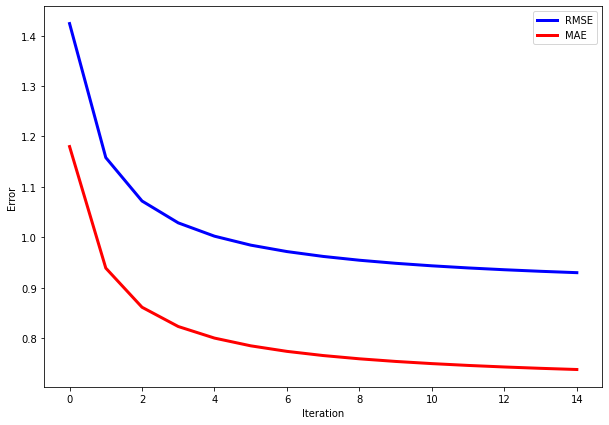

In [ ]:
 plt.figure(figsize=(10,7))
plt.plot(rmse_hist, label='RMSE', color='blue', linewidth=3)
plt.plot(mae_hist, label='MAE', color='red', linewidth=3)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()

In [ ]:
#prediction for validation set
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id-1]
    item_preference = latent_item_features[masked.columns.get_loc(item_id)]
    return user_preference.dot(item_preference)


error_list = []
for i,j in zip(test_set['user_id'],test_set['movie_id']):
  error_list.append(predict_rating(i,j) - test_set[(test_set['user_id'] == i) & (test_set['movie_id'] == j)]['rating'])

final_mse = np.sqrt((np.array(error_list)**2).mean())
print(final_mse)

0.9420824198323388


In [ ]:
#prediction for 0s
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


for i,j in zip(np.where(masked_arr==0)[0], np.where(masked_arr==0)[1]):
  masked_arr[i,j] = predict_rating(i,j)


RECOMMENDATION

In [ ]:
rec_matrix = pd.DataFrame(masked_arr, columns=masked.columns, index=masked.index) 

In [ ]:
#setting ratings to 0 for the movies that users have seen before
#rec_matrix = rec_matrix * masked.isna()

In [ ]:
def recommender(user_id, prediction_matrix, num_of_rec = 10):

    predictions = prediction_matrix.loc[user_id].values

    rating_df   = pd.DataFrame({'movie_id': list(masked.columns), 
                               'rating': predictions})
    final_df = rating_df.merge(movies, left_on='movie_id', right_on='movie_id').drop(['movie_id','genre'], axis=1)\
              .set_index('movie_name').sort_values('rating', ascending=False)[:num_of_rec]
    return final_df


In [ ]:
recommender(123, rec_matrix , 5)

,rating
movie_name,
It's a Wonderful Life (1946),5.0
"Mission, The (1986)",5.0
L.A. Confidential (1997),5.0
"Spitfire Grill, The (1996)",5.0
"Godfather, The (1972)",5.0


In [ ]:
def recommender(user_id,n,prediction_matrix):
  recommend_df = prediction_matrix.loc[prediction_matrix.index==user_id].T.reset_index()
  recommend_df.columns = ['movie_id','ratings']
  recommend_df = recommend_df.sort_values(by='ratings', ascending=False).head(n)
  recommend_df['movie_id'] = recommend_df['movie_id'].astype(int)
  watched_movies = pd.merge(ratings[ratings['user_id'] == user_id].sort_values(by='rating',ascending=False).head(n), movies, on='movie_id')
  recommended_movies = pd.merge(recommend_df, movies, on='movie_id')
  #print(f'Watched movies by user {user_id}:', '\n', watched_movies[['movie_name','rating']],'\n')
  #print(f'Recommended movies to user {user_id}:', '\n', recommended_movies[['movie_name','ratings']])
  return recommended_movies[['movie_id','ratings']]

In [ ]:
def apk(actual, predicted, k=10):

    if len(actual) == 0:
      return 0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)


    return score / min(len(actual), k)

In [ ]:
def apk_user(user_id,k,prediction_matrix):
  mean_rating = masked[masked.index == user_id].mean(axis=1).values[0]
  user_test = test_set[test_set['user_id'] == user_id][['movie_id','rating']]
  user_liked_movies = user_test[user_test['rating'] >= mean_rating]['movie_id'].values
  recommended_movies = recommender(user_id,k,prediction_matrix)['movie_id'].values
  return apk(user_liked_movies, recommended_movies,k)

In [ ]:
apk_user(1,30,rec_matrix)

0.028571428571428574

In [ ]:
mean_apk_base = np.mean([apk_user(i,30, rec_matrix) for i in masked.index.unique()])

In [ ]:
mean_apk_base

0.002436850130949039